In [43]:
import tensorflow as tf
from tensorflow.keras import models, layers,optimizers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 5

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 13884 files belonging to 9 classes.


2025-05-29 21:18:59.086893: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-05-29 21:18:59.086929: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-29 21:18:59.086932: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-05-29 21:18:59.086944: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-29 21:18:59.086953: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
class_names = dataset.class_names
class_names

['Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
len(dataset)

434

In [25]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[3 4 1 3 4 0 4 8 0 0 6 3 1 4 0 8 5 3 6 1 6 5 6 0 4 0 4 8 6 3 3 8]


2025-05-29 21:19:45.490410: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-05-29 21:18:59.331840: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


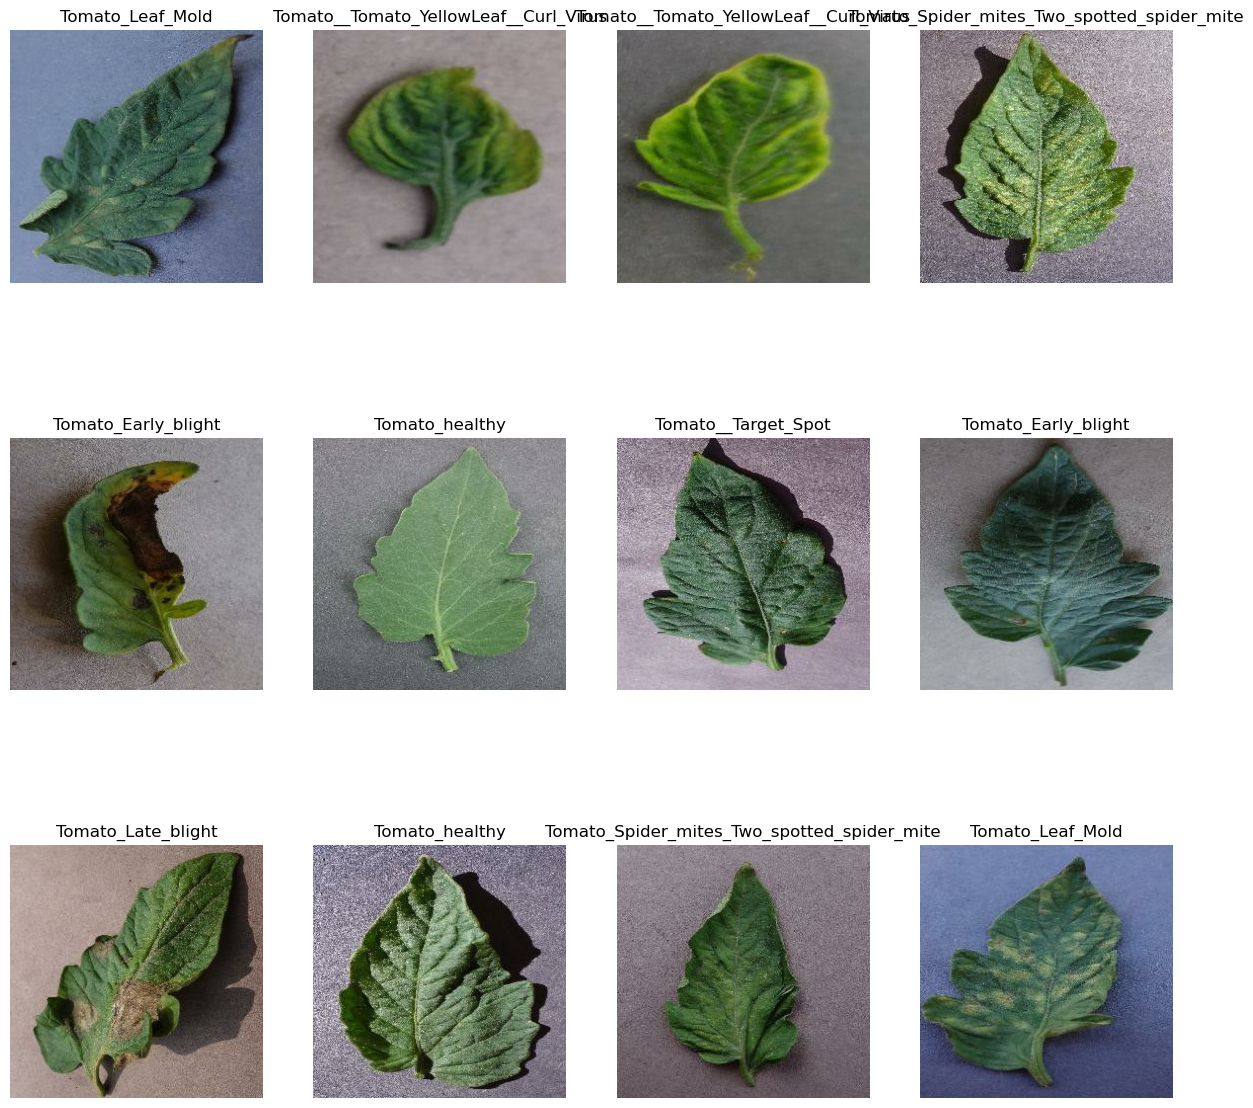

In [6]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [7]:
len(dataset)

434

In [8]:
train_size = 0.8
len(dataset)*train_size

347.20000000000005

In [9]:
train_ds = dataset.take(400)
len(train_ds)

400

In [10]:
test_ds = dataset.skip(400)
len(test_ds)

34

In [11]:
val_ds = 0.1
len(dataset)*val_ds

43.400000000000006

In [12]:
val_ds = test_ds.take(50)
len(val_ds)

34

In [13]:
test_ds = test_ds.skip(50)
len(test_ds)

0

In [14]:
def get_dataset_partitions_tf(ds,train_split = 0.8 ,val_split = 0.1,test_split = 0.1 , shuffle=True,shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [15]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

347

In [17]:
len(val_ds)

43

In [18]:
len(test_ds)

44

In [19]:
train_ds=train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [55]:
from tensorflow.keras.applications import MobileNetV2
input_shape = (IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 9
def build_mobilenet_model(input_shape, num_classes):
    base_model = MobileNetV2(input_shape=input_shape,
                             include_top=False,
                             weights='imagenet')
    base_model.trainable = False
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x) 
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=predictions)  
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model, base_model

def fine_tune_mobilenet_model(model, base_model, fine_tune_at_layer=None):
    base_model.trainable = True
    if fine_tune_at_layer is None:
        fine_tune_at_layer = 100
    for layer in base_model.layers[:fine_tune_at_layer]:
        layer.trainable = False   
    print(f"\nRe-compiling model for fine-tuning from layer {fine_tune_at_layer}...")
    model.compile(optimizer=optimizers.Adam(learning_rate=0.00001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model
num_classes = n_classes 
model, base_model = build_mobilenet_model(input_shape, num_classes)
model.summary()
fine_tuned_model = fine_tune_mobilenet_model(model, base_model, fine_tune_at_layer=120)
fine_tuned_model.summary()

/var/folders/xw/qpvhn1cn243fvnrg8zlsqjhw0000gn/T/ipykernel_23669/1969761869.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=input_shape,


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 2,423,113 (9.24 MB)

 Trainable params: 165,129 (645.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Re-compiling model for fine-tuning from layer 120...


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 2,423,113 (9.24 MB)

 Trainable params: 1,790,025 (6.83 MB)

 Non-trainable params: 633,088 (2.42 MB)

In [56]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [49]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
)

Epoch 1/5
347/347 ━━━━━━━━━━━━━━━━━━━━ 150s 412ms/step - accuracy: 0.5649 - loss: 1.2387 - val_accuracy: 0.2972 - val_loss: 4.9720
Epoch 2/5
347/347 ━━━━━━━━━━━━━━━━━━━━ 158s 455ms/step - accuracy: 0.8735 - loss: 0.3627 - val_accuracy: 0.3161 - val_loss: 3.5096
Epoch 3/5
347/347 ━━━━━━━━━━━━━━━━━━━━ 232s 668ms/step - accuracy: 0.9435 - loss: 0.1733 - val_accuracy: 0.3394 - val_loss: 3.3313
Epoch 4/5
347/347 ━━━━━━━━━━━━━━━━━━━━ 214s 616ms/step - accuracy: 0.9769 - loss: 0.0763 - val_accuracy: 0.6410 - val_loss: 1.0276
Epoch 5/5
347/347 ━━━━━━━━━━━━━━━━━━━━ 185s 532ms/step - accuracy: 0.9920 - loss: 0.0349 - val_accuracy: 0.7849 - val_loss: 0.6785


In [50]:
scores = model.evaluate(test_ds)

44/44 ━━━━━━━━━━━━━━━━━━━━ 11s 232ms/step - accuracy: 0.7716 - loss: 0.6761


In [51]:
scores

[0.6576357483863831, 0.7826704382896423]

first Image to predict
actual Image: Tomato_Septoria_leaf_spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
predicted Label: Tomato_Septoria_leaf_spot


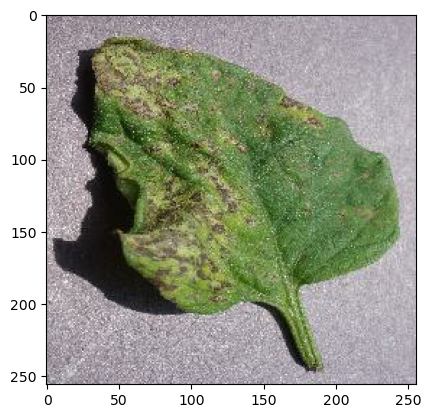

In [52]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()
    print("first Image to predict")
    plt.imshow(first_image)
    print("actual Image:",class_names[first_label])
    batch_prediction = model.predict(image_batch)
    print("predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [53]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) #create a batch
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class , confidence
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━

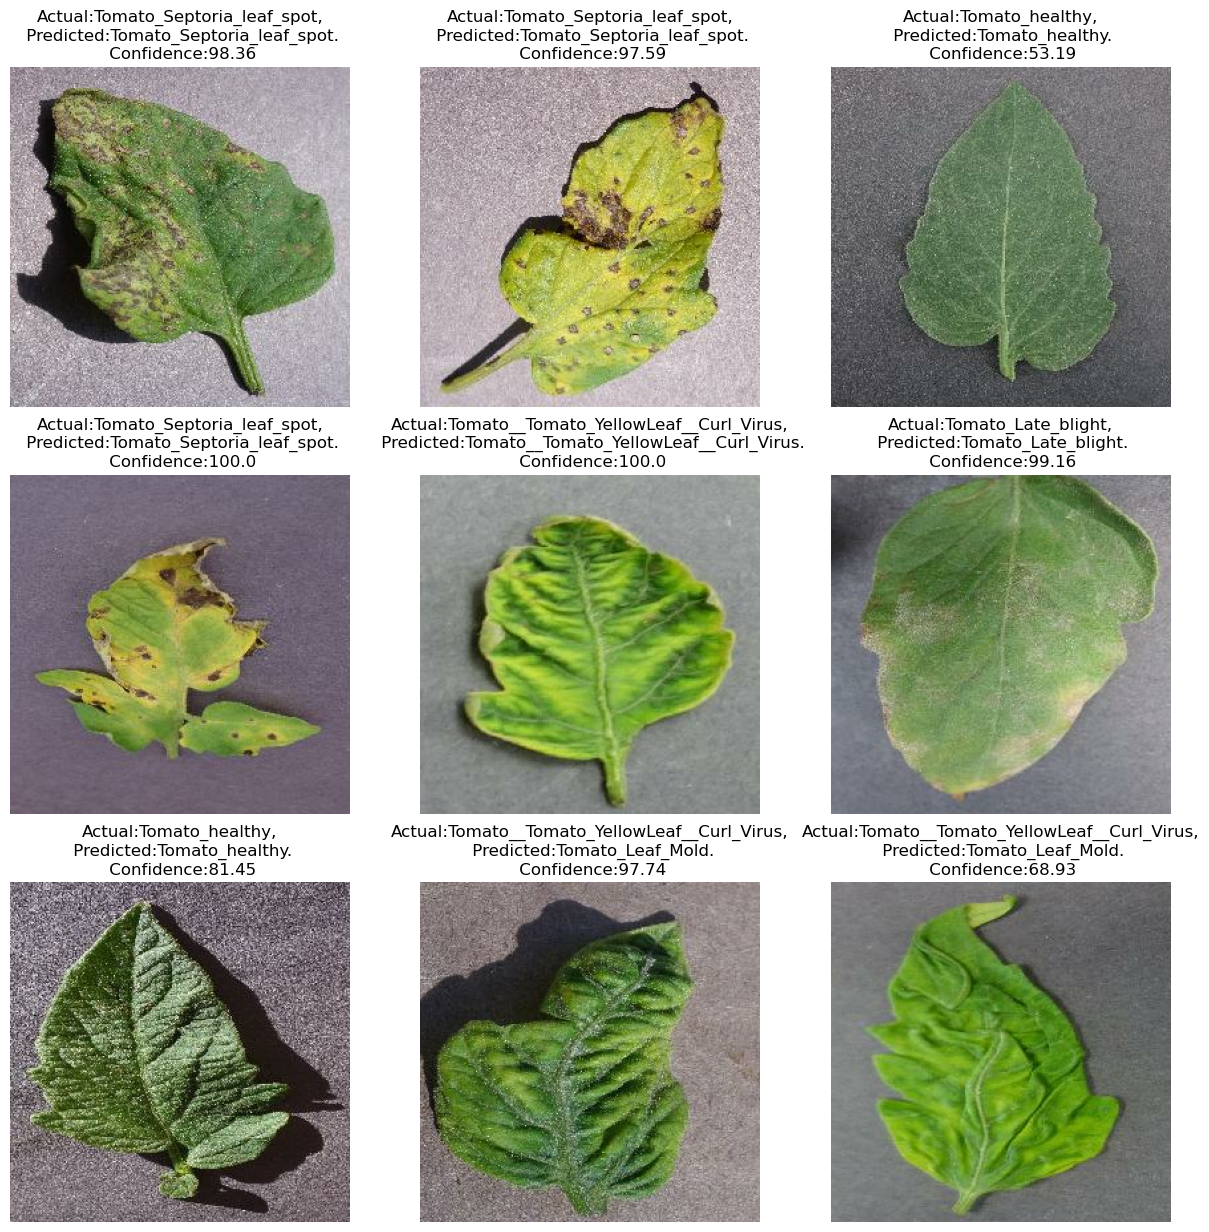

In [54]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(i):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class}.\n Confidence:{confidence}")
        plt.axis('off')
        plt.show

In [57]:
model_version = 1
save_path = f"../models/{model_version}.keras"
model.save(save_path)
print(f"Model saved to {save_path}")

Model saved to ../models/1.keras
